<Axes: xlabel='date'>

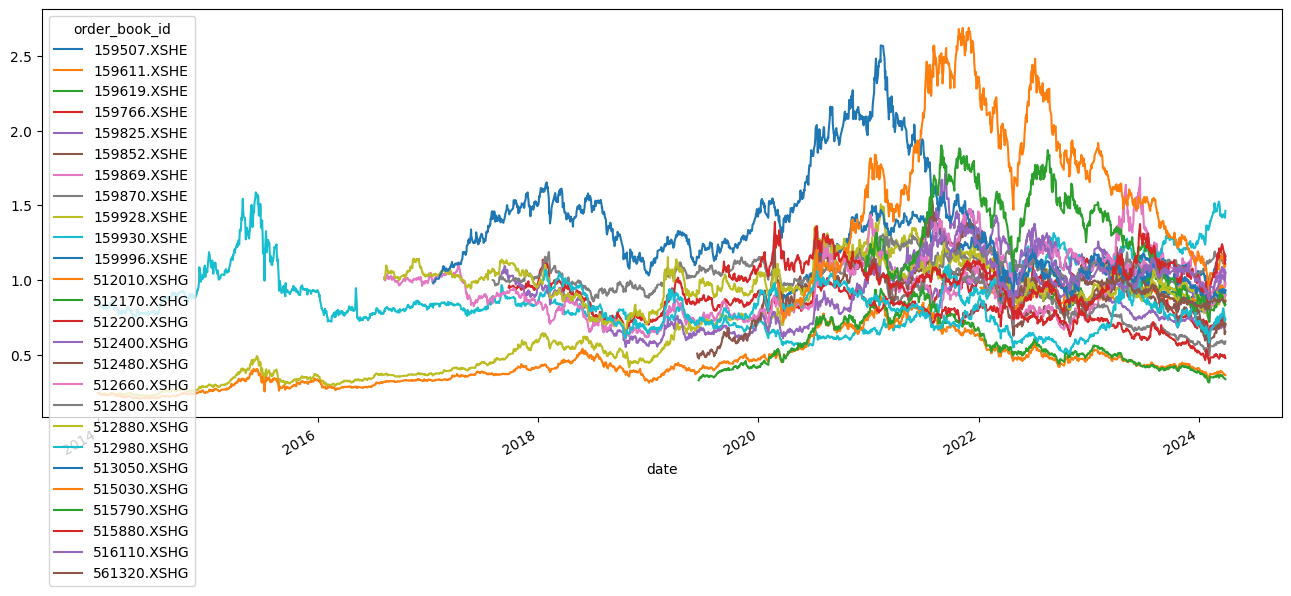

In [24]:
df_price.plot(figsize = (16,6))

##### ATR止盈止损

2014-04-10 00:00:00: 买入 159928.XSHE, 价格 0.242, 数量 10330
2014-04-10 00:00:00: 买入 159930.XSHE, 价格 0.821, 数量 3045
2014-04-11 00:00:00: 卖出 159930.XSHE, 价格 0.81, 数量 3045
2014-04-21 00:00:00: 卖出 159928.XSHE, 价格 0.2382, 数量 10330
2014-06-30 00:00:00: 买入 512010.XSHG, 价格 0.213, 数量 11651
2014-07-02 00:00:00: 买入 159930.XSHE, 价格 0.789, 数量 3145
2014-07-03 00:00:00: 买入 159928.XSHE, 价格 0.2302, 数量 10782
2014-07-09 00:00:00: 卖出 159928.XSHE, 价格 0.227, 数量 10782
2014-07-09 00:00:00: 卖出 159930.XSHE, 价格 0.778, 数量 3145
2014-07-09 00:00:00: 卖出 512010.XSHG, 价格 0.2078, 数量 11651
2014-07-14 00:00:00: 买入 159928.XSHE, 价格 0.2315, 数量 10580
2014-07-24 00:00:00: 买入 159930.XSHE, 价格 0.799, 数量 3065
2014-07-28 00:00:00: 买入 512010.XSHG, 价格 0.2168, 数量 11299
2014-08-07 00:00:00: 卖出 512010.XSHG, 价格 0.219, 数量 11299
2014-08-08 00:00:00: 卖出 159930.XSHE, 价格 0.857, 数量 3065
2014-08-13 00:00:00: 买入 159930.XSHE, 价格 0.88, 数量 2860
2014-08-26 00:00:00: 卖出 159928.XSHE, 价格 0.2512, 数量 10580
2014-08-26 00:00:00: 卖出 159930.XSHE, 价格 0.861, 数量 2

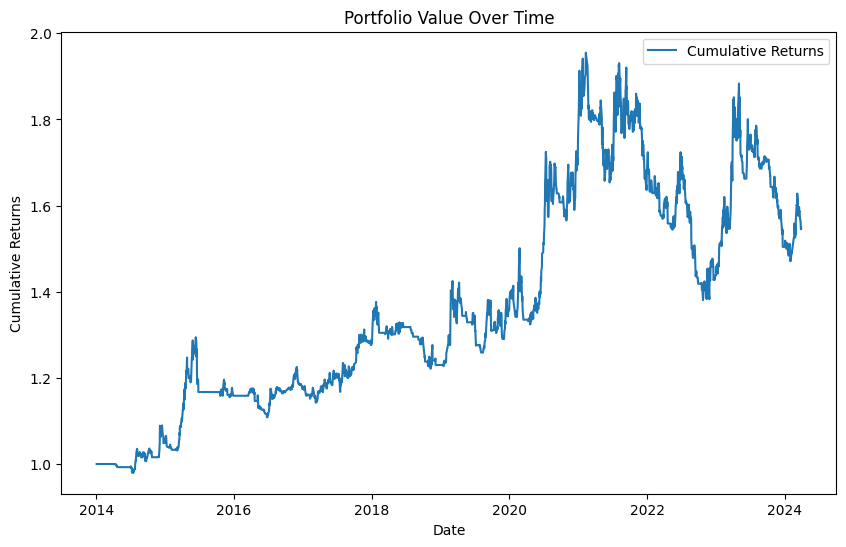

初始资金: 10000
最终资金: 15486.079899999999
年化收益率: 4.49%
最大回撤: -29.38%
夏普比率: 0.37


In [177]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


df = df_price.copy()

initial_capital = 10000
positions = 4  # 仓位数
slippage_and_fees = 0.00  # 滑点手续费
portfolio_value_tracker = []

capital = initial_capital
cash = initial_capital  
etf_value = 0
holdings = {etf: 0 for etf in df.columns} 
peak = {etf: 0 for etf in df.columns}

def check_buy_signals(etf, price_data, current_date, start_date):
    if current_date < start_date + pd.Timedelta(days=30):
        return False
    return price_data[-1] > max(price_data[-31:-1])

def buy(etf, price, date):
    global capital, cash, etf_value, holdings
    if not np.isnan(price) and holdings[etf] == 0:
        num_held_etfs = sum(1 for h in holdings.values() if h > 0)
        # 如果持有的ETF数量小于4，计算当前应该投入的资金
        if num_held_etfs < positions:
            # 仅使用现金计算可投资资金
            investable_cash = cash / (positions - num_held_etfs)
            etf_amount = int(investable_cash * (1 - slippage_and_fees) / price)
            holdings[etf] = etf_amount
            cash -= etf_amount * price  
            peak[etf] = price
            print(f"{date}: 买入 {etf}, 价格 {price}, 数量 {etf_amount}")


def sell(etf, price, date):
    global capital, cash, etf_value, holdings
    if not np.isnan(price) and holdings[etf] > 0:
        proceeds = holdings[etf] * price * (1 - slippage_and_fees)
        cash += proceeds 
        etf_value -= holdings[etf] * price
        print(f"{date}: 卖出 {etf}, 价格 {price}, 数量 {holdings[etf]}")
        holdings[etf] = 0


def check_stop_conditions(etf, price, atr):
    if holdings[etf] <= 0:
        return False
    if price < peak[etf] - 1 * atr:  # 止损条件
        return True
    if price > peak[etf] + 2 * atr:  # 止盈条件
        peak[etf] = price
    return False


start_date = df.index[0]
for date, prices in df.iterrows():
    atr_values = df_atr.loc[date]  # 获取当天的ATR值
    for etf, price in prices.items():
        if check_stop_conditions(etf, price, atr_values[etf]):
            sell(etf, price, date)

    # 检查买入信号，如果满足条件则买入
    for etf in prices.index:
        price_data = df[etf].loc[:date]
        if check_buy_signals(etf, price_data, date, start_date):
            num_held_etfs = sum(1 for h in holdings.values() if h > 0)
            if num_held_etfs < positions:
                buy(etf, prices[etf], date)

    # 更新ETF市值和资金
    etf_value = sum(holdings[etf] * prices[etf] for etf in prices.index if holdings[etf] > 0)
    capital = cash + etf_value
    portfolio_value_tracker.append(capital)
    
portfolio_values = np.array(portfolio_value_tracker)
returns = portfolio_values[1:] / portfolio_values[:-1] - 1
cumulative_returns = portfolio_values / initial_capital - 1

# 年化收益率
annualized_return = (portfolio_values[-1] / portfolio_values[0])**(250/len(portfolio_values))-1
rolling_max = np.maximum.accumulate(portfolio_values)
daily_drawdown = portfolio_values / rolling_max - 1
max_drawdown = np.min(daily_drawdown)

average_daily_return = np.mean(returns)
std_dev = np.std(returns)
sharp_ratio = (average_daily_return / std_dev) * np.sqrt(252)

plt.figure(figsize=(10, 6))
plt.plot(df.index, portfolio_values/10000, label='Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Portfolio Value Over Time')
plt.legend()
plt.show()

print(f"初始资金: {initial_capital}")
print(f"最终资金: {portfolio_values[-1]}")
print(f"年化收益率: {annualized_return:.2%}")
print(f"最大回撤: {max_drawdown:.2%}")
print(f"夏普比率: {sharp_ratio:.2f}")

In [138]:
n1 = portfolio_values

2014-03-21 00:00:00: 买入 159928.XSHE, 价格 0.2375, 数量 10526
2014-03-27 00:00:00: 卖出 159928.XSHE, 价格 0.231, 数量 10526
2014-04-08 00:00:00: 买入 159928.XSHE, 价格 0.2388, 数量 10397
2014-04-09 00:00:00: 买入 159930.XSHE, 价格 0.8079999999999999, 数量 3072
2014-04-17 00:00:00: 卖出 159930.XSHE, 价格 0.7959999999999999, 数量 3072
2014-04-25 00:00:00: 卖出 159928.XSHE, 价格 0.2322, 数量 10397
2014-05-12 00:00:00: 买入 159930.XSHE, 价格 0.8029999999999999, 数量 3059
2014-05-15 00:00:00: 卖出 159930.XSHE, 价格 0.779, 数量 3059
2014-06-11 00:00:00: 买入 512010.XSHG, 价格 0.2125, 数量 11473
2014-06-16 00:00:00: 买入 159930.XSHE, 价格 0.7879999999999999, 数量 3094
2014-06-18 00:00:00: 卖出 159930.XSHE, 价格 0.7809999999999999, 数量 3094
2014-06-19 00:00:00: 卖出 512010.XSHG, 价格 0.2065, 数量 11473
2014-06-25 00:00:00: 买入 159930.XSHE, 价格 0.78, 数量 3096
2014-06-27 00:00:00: 买入 512010.XSHG, 价格 0.212, 数量 11395
2014-07-02 00:00:00: 买入 159928.XSHE, 价格 0.2288, 数量 10558
2014-07-09 00:00:00: 卖出 512010.XSHG, 价格 0.2078, 数量 11395
2014-07-10 00:00:00: 卖出 159928.XSHE, 价格 

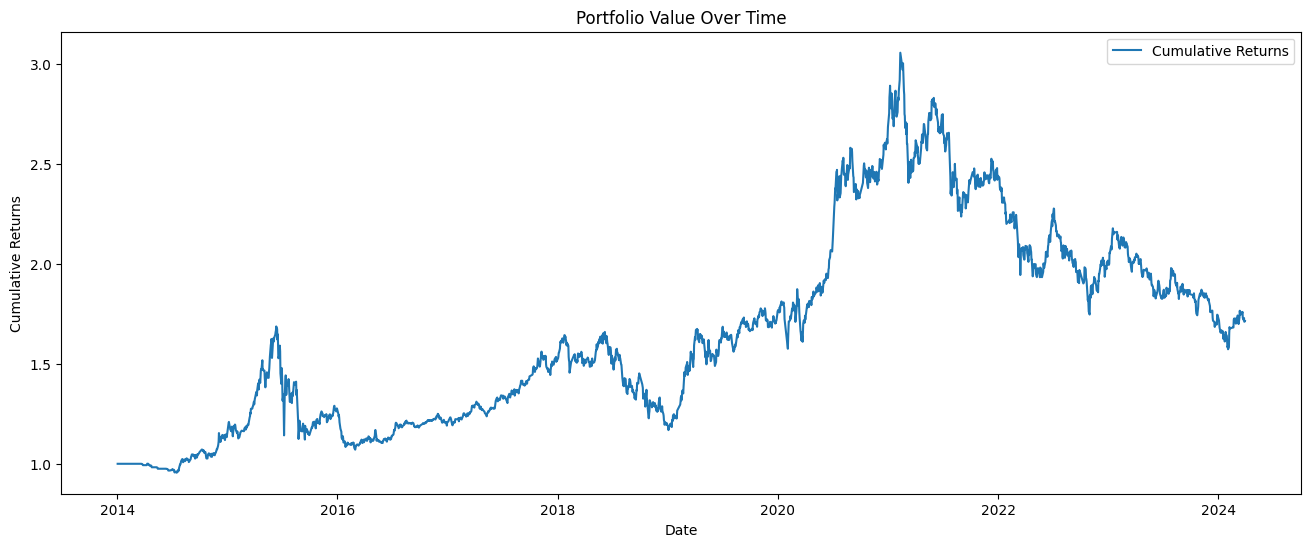

初始资金: 10000
最终资金: 17144.547800000004
年化收益率: 5.56%
最大回撤: -48.55%
夏普比率: 0.36
上涨了2个ATR后未触及止盈点然后下跌1个ATR的情况比例: 0.00%


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = df_price.copy()

initial_capital = 10000
positions = 4  # 仓位数
slippage_and_fees = 0.00  # 滑点手续费
portfolio_value_tracker = []


capital = initial_capital
cash = initial_capital  
etf_value = 0
holdings = {etf: 0 for etf in df.columns} 
peak = {etf: 0 for etf in df.columns}
stop_loss_price = {etf: 0 for etf in df.columns}  # 止损价
take_profit_price = {etf: 0 for etf in df.columns}  # 止盈价

def check_buy_signals(etf, df, current_date):
    if current_date < df.index[50]:
        return False
    ma10 = df[etf].rolling(window=50).mean()
    today_close = df.at[current_date, etf]
    yesterday_close = df.at[df.index[df.index.get_loc(current_date) - 1], etf]
    yesterday_ma10 = ma10[df.index.get_loc(current_date) - 1]

    if yesterday_close < yesterday_ma10 and today_close > ma10[current_date]:
        return True
    return False

def buy(etf, price, date, atr):
    global capital, cash, etf_value, holdings, stop_loss_price, take_profit_price
    if not np.isnan(price) and holdings[etf] == 0:
        num_held_etfs = sum(1 for h in holdings.values() if h > 0)
        # 如果持有的ETF数量小于4，计算当前应该投入的资金
        if num_held_etfs < positions:
            # 仅使用现金计算可投资资金
            investable_cash = cash / (positions - num_held_etfs)
            etf_amount = int(investable_cash * (1 - slippage_and_fees) / price)
            holdings[etf] = etf_amount
            cash -= etf_amount * price
            peak[etf] = price
            # 设置初始的止盈价和止损价
            stop_loss_price[etf] = price - 1 * atr
            take_profit_price[etf] = price + 2 * atr
            print(f"{date}: 买入 {etf}, 价格 {price}, 数量 {etf_amount}")


def sell(etf, price, date):
    global capital, cash, etf_value, holdings
    if not np.isnan(price) and holdings[etf] > 0:
        proceeds = holdings[etf] * price * (1 - slippage_and_fees)
        cash += proceeds 
        etf_value -= holdings[etf] * price
        print(f"{date}: 卖出 {etf}, 价格 {price}, 数量 {holdings[etf]}")
        holdings[etf] = 0


# 在策略代码中定义计数器
moves_without_profit_count = 0
moves_with_2atr_rise_count = 0

# 检查止损条件的函数中，我们需要添加逻辑来检查
# 是否价格已经上涨了2个ATR但未触及止盈点，然后下跌了1个ATR
def check_stop_conditions(etf, price, atr):
    global holdings, peak, stop_loss_price, take_profit_price, moves_without_profit_count, moves_with_2atr_rise_count
    if holdings[etf] <= 0:
        return False
    # 检查是否已经上涨了2个ATR
    if price >= peak[etf] + 2 * atr:
        moves_with_2atr_rise_count += 1
        # 检查是否未触及止盈点然后下跌了1个ATR
        if price <= peak[etf] + atr:
            moves_without_profit_count += 1
        peak[etf] = max(peak[etf], price)  # 更新峰值价格
    if price <= stop_loss_price[etf]:
        return True
    return False


start_date = df.index[0]
for date, prices in df.iterrows():
    atr_values = df_atr.loc[date]  # 获取当天的ATR值
    for etf, price in prices.items():
        if check_stop_conditions(etf, price, atr_values[etf]):
            sell(etf, price, date)

    # 检查买入信号，如果满足条件则买入
    for etf in prices.index:
        if check_buy_signals(etf, df, date):
            num_held_etfs = sum(1 for h in holdings.values() if h > 0)
            if num_held_etfs < positions:
                atr = atr_values[etf]
                buy(etf, prices[etf], date, atr)

    # 更新ETF市值和资金
    etf_value = sum(holdings[etf] * prices[etf] for etf in prices.index if holdings[etf] > 0)
    capital = cash + etf_value
    portfolio_value_tracker.append(capital)
    
portfolio_values = np.array(portfolio_value_tracker)
returns = portfolio_values[1:] / portfolio_values[:-1] - 1
cumulative_returns = portfolio_values / initial_capital - 1

# 年化收益率
annualized_return = (portfolio_values[-1] / portfolio_values[0])**(250/len(portfolio_values))-1
rolling_max = np.maximum.accumulate(portfolio_values)
daily_drawdown = portfolio_values / rolling_max - 1
max_drawdown = np.min(daily_drawdown)

average_daily_return = np.mean(returns)
std_dev = np.std(returns)
sharp_ratio = (average_daily_return / std_dev) * np.sqrt(252)

plt.figure(figsize=(16, 6))
plt.plot(df.index, portfolio_values/10000, label='Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Portfolio Value Over Time')
plt.legend()
plt.show()

print(f"初始资金: {initial_capital}")
print(f"最终资金: {portfolio_values[-1]}")
print(f"年化收益率: {annualized_return:.2%}")
print(f"最大回撤: {max_drawdown:.2%}")
print(f"夏普比率: {sharp_ratio:.2f}")
ratio = moves_without_profit_count / moves_with_2atr_rise_count if moves_with_2atr_rise_count else 0
print(f"上涨了2个ATR后未触及止盈点然后下跌1个ATR的情况比例: {ratio:.2%}")

In [27]:
n1 = portfolio_values
n1

array([10000.   , 10000.   , 10000.   , ..., 19183.697, 19182.992,
       19406.135])

In [30]:
n2 = portfolio_values
n2

array([10000.    , 10000.    , 10000.    , ..., 24985.5374, 25101.1964,
       25225.1304])

In [31]:
np.corrcoef(n1,n2)

array([[1.        , 0.96301015],
       [0.96301015, 1.        ]])

2014-03-21 00:00:00: 买入 159928.XSHE, 价格 0.2375, 数量 10526
2014-03-28 00:00:00: 卖出 159928.XSHE, 价格 0.2282, 数量 10526
2014-04-08 00:00:00: 买入 159928.XSHE, 价格 0.2388, 数量 10366
2014-04-09 00:00:00: 买入 159930.XSHE, 价格 0.8079999999999999, 数量 3063
2014-04-21 00:00:00: 卖出 159930.XSHE, 价格 0.784, 数量 3063
2014-04-25 00:00:00: 卖出 159928.XSHE, 价格 0.2322, 数量 10366
2014-05-12 00:00:00: 买入 159930.XSHE, 价格 0.8029999999999999, 数量 3038
2014-05-15 00:00:00: 卖出 159930.XSHE, 价格 0.779, 数量 3038
2014-06-11 00:00:00: 买入 512010.XSHG, 价格 0.2125, 数量 11396
2014-06-16 00:00:00: 买入 159930.XSHE, 价格 0.7879999999999999, 数量 3073
2014-06-19 00:00:00: 卖出 159930.XSHE, 价格 0.764, 数量 3073
2014-06-19 00:00:00: 卖出 512010.XSHG, 价格 0.2065, 数量 11396
2014-06-25 00:00:00: 买入 159930.XSHE, 价格 0.78, 数量 3059
2014-06-27 00:00:00: 买入 512010.XSHG, 价格 0.212, 数量 11256
2014-07-02 00:00:00: 买入 159928.XSHE, 价格 0.2288, 数量 10430
2014-07-09 00:00:00: 卖出 512010.XSHG, 价格 0.2078, 数量 11256
2014-07-15 00:00:00: 买入 512010.XSHG, 价格 0.2118, 数量 11155
2014-08-

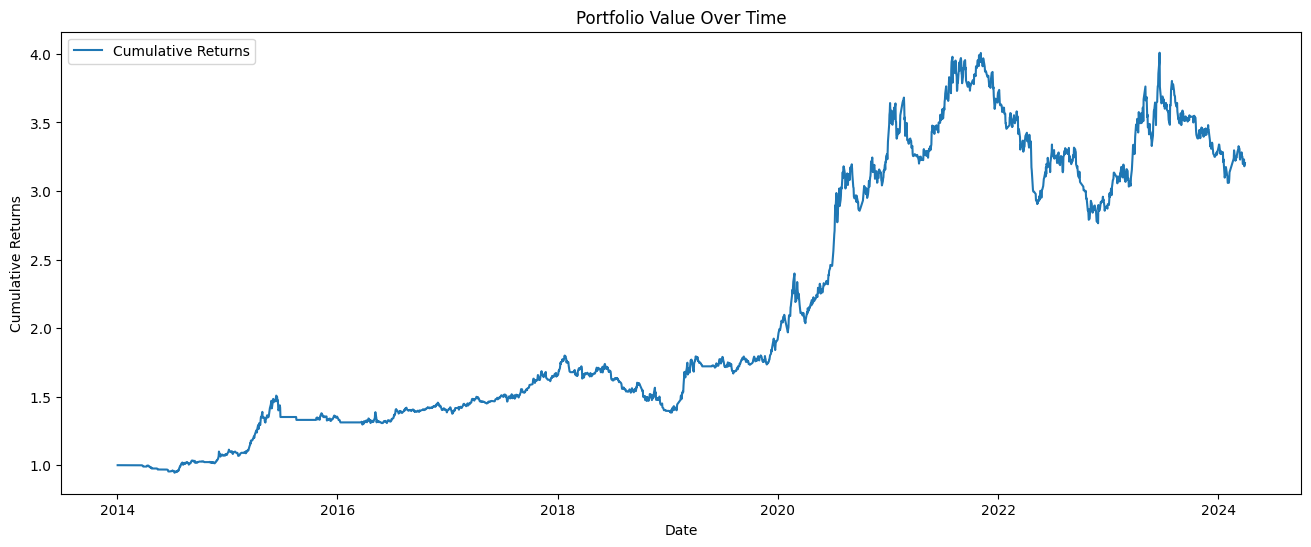

初始资金: 10000
最终资金: 32032.34680000002
年化收益率: 12.39%
最大回撤: -31.00%
夏普比率: 0.80


In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = df_price.copy()

initial_capital = 10000
positions = 4  # 仓位数
slippage_and_fees = 0.00  # 滑点手续费
portfolio_value_tracker = []
trade_slips = []

capital = initial_capital
cash = initial_capital  
etf_value = 0
holdings = {etf: 0 for etf in df.columns} 
peak = {etf: 0 for etf in df.columns}

def check_buy_signals(etf, df, current_date):
    if current_date < df.index[50]:
        return False
    ma10 = df[etf].rolling(window=50).mean()
    today_close = df.at[current_date, etf]
    yesterday_close = df.at[df.index[df.index.get_loc(current_date) - 1], etf]
    yesterday_ma10 = ma10[df.index.get_loc(current_date) - 1]

    if yesterday_close < yesterday_ma10 and today_close > ma10[current_date]:
        return True
    return False

def buy(etf, price, date):
    global capital, cash, etf_value, holdings
    if not np.isnan(price) and holdings[etf] == 0:
        num_held_etfs = sum(1 for h in holdings.values() if h > 0)
        # 如果持有的ETF数量小于4，计算当前应该投入的资金
        if num_held_etfs < positions:
            # 仅使用现金计算可投资资金
            investable_cash = cash / (positions - num_held_etfs)
            etf_amount = int(investable_cash * (1 - slippage_and_fees) / price)
            holdings[etf] = etf_amount
            cash -= etf_amount * price  
            peak[etf] = price
            print(f"{date}: 买入 {etf}, 价格 {price}, 数量 {etf_amount}")
        trade_slips.append({'date': date, 'etf': etf, 'action': 'BUY', 'price': price, 'quantity': etf_amount, 'total': etf_amount * price})


def sell(etf, price, date):
    global capital, cash, etf_value, holdings
    if not np.isnan(price) and holdings[etf] > 0:
        proceeds = holdings[etf] * price * (1 - slippage_and_fees)
        cash += proceeds 
        etf_value -= holdings[etf] * price
        print(f"{date}: 卖出 {etf}, 价格 {price}, 数量 {holdings[etf]}")
        holdings[etf] = 0
    trade_slips.append({'date': date, 'etf': etf, 'action': 'SELL', 'price': price, 'quantity': holdings[etf], 'total': proceeds})

def calculate_pnl(trade_slips):
    daily_pnl = 0
    for trade in trade_slips:
        if trade['action'] == 'SELL':
            # 计算卖出交易的盈亏
            buy_total = next(item['total'] for item in trade_slips if item['action'] == 'BUY' and item['etf'] == trade['etf'])
            daily_pnl += trade['total'] - buy_total
    return daily_pnl

def check_stop_conditions(etf, price, atr):
    if holdings[etf] <= 0:
        return False
    if price < peak[etf] - 1.5 * atr:  # 止损条件
        return True
    if price > peak[etf] + 3 * atr:  # 止盈条件
        peak[etf] = price
    return False

daily_pnl_tracker = []
cumulative_pnl = 0
start_date = df.index[0]
for date, prices in df.iterrows():
    atr_values = df_atr.loc[date]  # 获取当天的ATR值
    for etf, price in prices.items():
        if check_stop_conditions(etf, price, atr_values[etf]):
            sell(etf, price, date)

    # 检查买入信号，如果满足条件则买入
    for etf in prices.index:
        if check_buy_signals(etf, df, date):
            num_held_etfs = sum(1 for h in holdings.values() if h > 0)
            if num_held_etfs < positions:
                buy(etf, prices[etf], date)
    
    daily_pnl = calculate_pnl(trade_slips)
    cumulative_pnl += daily_pnl  # 更新累计盈亏
    daily_pnl_tracker.append({'date': date, 'daily_pnl': daily_pnl, 'cumulative_pnl': cumulative_pnl})
    
    # 更新ETF市值和资金
    etf_value = sum(holdings[etf] * prices[etf] for etf in prices.index if holdings[etf] > 0)
    capital = cash + etf_value
    portfolio_value_tracker.append(capital)
    
portfolio_values = np.array(portfolio_value_tracker)
returns = portfolio_values[1:] / portfolio_values[:-1] - 1
cumulative_returns = portfolio_values / initial_capital - 1

df_trade_slips = pd.DataFrame(trade_slips)
df_daily_pnl = pd.DataFrame(daily_pnl_tracker)

print("交割单:")
print(df_trade_slips)
print("\n每日盈亏:")
print(df_daily_pnl)

# 年化收益率
annualized_return = (portfolio_values[-1] / portfolio_values[0])**(250/len(portfolio_values))-1
rolling_max = np.maximum.accumulate(portfolio_values)
daily_drawdown = portfolio_values / rolling_max - 1
max_drawdown = np.min(daily_drawdown)

average_daily_return = np.mean(returns)
std_dev = np.std(returns)
sharp_ratio = (average_daily_return / std_dev) * np.sqrt(252)

plt.figure(figsize=(16, 6))
plt.plot(df.index, portfolio_values/10000, label='Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Portfolio Value Over Time')
plt.legend()
plt.show()

print(f"初始资金: {initial_capital}")
print(f"最终资金: {portfolio_values[-1]}")
print(f"年化收益率: {annualized_return:.2%}")
print(f"最大回撤: {max_drawdown:.2%}")
print(f"夏普比率: {sharp_ratio:.2f}")

In [17]:
len(portfolio_values)

2492

4
0
2014-03-21 00:00:00: 买入 159928.XSHE, 价格 0.2375, 数量 10526
2014-03-28 00:00:00: 卖出 159928.XSHE, 价格 0.2282, 数量 10526
4
0
2014-04-08 00:00:00: 买入 159928.XSHE, 价格 0.2388, 数量 10366
4
1
2014-04-09 00:00:00: 买入 159930.XSHE, 价格 0.8079999999999999, 数量 3063
2014-04-21 00:00:00: 卖出 159930.XSHE, 价格 0.784, 数量 3063
2014-04-25 00:00:00: 卖出 159928.XSHE, 价格 0.2322, 数量 10366
4
0
2014-05-12 00:00:00: 买入 159930.XSHE, 价格 0.8029999999999999, 数量 3038
2014-05-15 00:00:00: 卖出 159930.XSHE, 价格 0.779, 数量 3038
4
0
2014-06-11 00:00:00: 买入 512010.XSHG, 价格 0.2125, 数量 11396
4
1
2014-06-16 00:00:00: 买入 159930.XSHE, 价格 0.7879999999999999, 数量 3073
2014-06-19 00:00:00: 卖出 159930.XSHE, 价格 0.764, 数量 3073
2014-06-19 00:00:00: 卖出 512010.XSHG, 价格 0.2065, 数量 11396
4
0
2014-06-25 00:00:00: 买入 159930.XSHE, 价格 0.78, 数量 3059
4
1
2014-06-27 00:00:00: 买入 512010.XSHG, 价格 0.212, 数量 11256
4
2
2014-07-02 00:00:00: 买入 159928.XSHE, 价格 0.2288, 数量 10430
2014-07-09 00:00:00: 卖出 512010.XSHG, 价格 0.2078, 数量 11256
4
2
2014-07-15 00:00:00: 买入 5

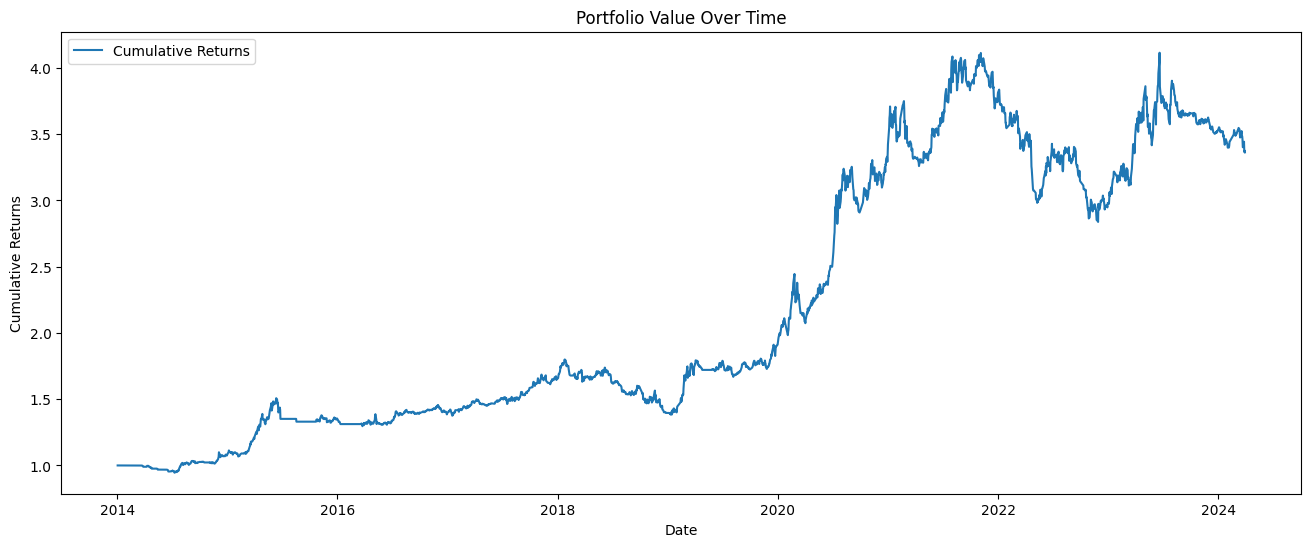

初始资金: 10000
最终资金: 33629.912300000025
年化收益率: 12.94%
最大回撤: -31.00%
夏普比率: 0.84


In [71]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = df_price.copy()
initial_capital = 10000
positions = 4  # 仓位数
slippage_and_fees = 0.00  # 滑点手续费
portfolio_value_tracker = []
trade_slips = []
capital = initial_capital
cash = initial_capital  
etf_value = 0
holdings = {etf: 0 for etf in df.columns} 
peak = {etf: 0 for etf in df.columns}


def calculate_position(df, current_date):
    global positions
    ma50 = df['510300.XSHG'].rolling(window=50).mean()
    if current_date not in df.index:
        return  
    today_close = df.at[current_date, '510300.XSHG']
    if current_date in ma50.index: 
        today_ma50 = ma50[current_date]
        previous_market_day_index = df.index.get_loc(current_date) - 1
        if previous_market_day_index >= 0: 
            previous_market_day = df.index[previous_market_day_index]
            yesterday_close = df.at[previous_market_day, '510300.XSHG']
            yesterday_ma50 = ma50[previous_market_day]
            if yesterday_close < yesterday_ma50 and today_close > today_ma50:
                positions = 4 
            elif yesterday_close > yesterday_ma50 and today_close < today_ma50:
                positions = 8
    

def check_buy_signals(etf, df, current_date):
    if current_date < df.index[50]:
        return False
    ma10 = df[etf].rolling(window=50).mean()
    today_close = df.at[current_date, etf]
    yesterday_close = df.at[df.index[df.index.get_loc(current_date) - 1], etf]
    yesterday_ma10 = ma10[df.index.get_loc(current_date) - 1]

    if yesterday_close < yesterday_ma10 and today_close > ma10[current_date]:
        return True
    return False

def buy(etf, price, date):
    global capital, cash, etf_value, holdings
    calculate_position(df_hs300, date) 
    if not np.isnan(price) and holdings[etf] == 0:
        num_held_etfs = sum(1 for h in holdings.values() if h > 0)
        # 如果持有的ETF数量小于4，计算当前应该投入的资金
        if num_held_etfs < 4:
            # 仅使用现金计算可投资资金
            print(positions)
            print(num_held_etfs)
            investable_cash = cash / (positions - num_held_etfs)
            etf_amount = int(investable_cash * (1 - slippage_and_fees) / price)
            holdings[etf] = etf_amount
            cash -= etf_amount * price  
            peak[etf] = price
            print(f"{date}: 买入 {etf}, 价格 {price}, 数量 {etf_amount}")


def sell(etf, price, date):
    global capital, cash, etf_value, holdings
    if not np.isnan(price) and holdings[etf] > 0:
        proceeds = holdings[etf] * price * (1 - slippage_and_fees)
        cash += proceeds 
        etf_value -= holdings[etf] * price
        print(f"{date}: 卖出 {etf}, 价格 {price}, 数量 {holdings[etf]}")
        holdings[etf] = 0

def calculate_pnl(trade_slips):
    daily_pnl = 0
    for trade in trade_slips:
        if trade['action'] == 'SELL':
            # 计算卖出交易的盈亏
            buy_total = next(item['total'] for item in trade_slips if item['action'] == 'BUY' and item['etf'] == trade['etf'])
            daily_pnl += trade['total'] - buy_total
    return daily_pnl

def check_stop_conditions(etf, price, atr):
    if holdings[etf] <= 0:
        return False
    if price < peak[etf] - 1.5 * atr:  # 止损条件
        return True
    if price > peak[etf] + 3 * atr:  # 止盈条件
        peak[etf] = price
    return False


start_date = df.index[0]
for date, prices in df.iterrows():
    atr_values = df_atr.loc[date]  # 获取当天的ATR值
    for etf, price in prices.items():
        if check_stop_conditions(etf, price, atr_values[etf]):
            sell(etf, price, date)

    # 检查买入信号，如果满足条件则买入
    for etf in prices.index:
        if check_buy_signals(etf, df, date):
            num_held_etfs = sum(1 for h in holdings.values() if h > 0)
            if num_held_etfs < positions:
                buy(etf, prices[etf], date)
    
    daily_pnl = calculate_pnl(trade_slips)
    cumulative_pnl += daily_pnl  # 更新累计盈亏

    # 更新ETF市值和资金
    etf_value = sum(holdings[etf] * prices[etf] for etf in prices.index if holdings[etf] > 0)
    capital = cash + etf_value
    portfolio_value_tracker.append(capital)
    
portfolio_values = np.array(portfolio_value_tracker)
returns = portfolio_values[1:] / portfolio_values[:-1] - 1
cumulative_returns = portfolio_values / initial_capital - 1

df_trade_slips = pd.DataFrame(trade_slips)
df_daily_pnl = pd.DataFrame(daily_pnl_tracker)

# 年化收益率
annualized_return = (portfolio_values[-1] / portfolio_values[0])**(250/len(portfolio_values))-1
rolling_max = np.maximum.accumulate(portfolio_values)
daily_drawdown = portfolio_values / rolling_max - 1
max_drawdown = np.min(daily_drawdown)

average_daily_return = np.mean(returns)
std_dev = np.std(returns)
sharp_ratio = (average_daily_return / std_dev) * np.sqrt(252)

plt.figure(figsize=(16, 6))
plt.plot(df.index, portfolio_values/10000, label='Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Portfolio Value Over Time')
plt.legend()
plt.show()

print(f"初始资金: {initial_capital}")
print(f"最终资金: {portfolio_values[-1]}")
print(f"年化收益率: {annualized_return:.2%}")
print(f"最大回撤: {max_drawdown:.2%}")
print(f"夏普比率: {sharp_ratio:.2f}")

In [61]:
import pandas as pd

def check_buy_signals(df, current_date):
    etfs_to_buy = []
    
    for etf in df.columns:
        if current_date < df.index[50]:
            continue
        
        ma50 = df[etf].rolling(window=50).mean()
        today_close = df.at[current_date, etf]
        yesterday_close = df.at[df.index[df.index.get_loc(current_date) - 1], etf]
        yesterday_ma50 = ma50[df.index.get_loc(current_date) - 1]

        if yesterday_close < yesterday_ma50 and today_close > ma50[current_date]:
            etfs_to_buy.append(etf)  
    
    return etfs_to_buy

etfs_to_buy_dict = {}

start_date = df.index[50] 
for current_date in df.index[df.index.get_loc(start_date):]:
    etfs_to_buy_dict[current_date] = check_buy_signals(df, current_date)
etfs_to_buy_df = pd.DataFrame(list(etfs_to_buy_dict.items()), columns=['Date', 'ETF'])
etfs_to_buy_df

,Date,ETF
0,2014-03-20,[]
1,2014-03-21,[159928.XSHE]
2,2014-03-24,[]
3,2014-03-25,[]
4,2014-03-26,[]
...,...,...
2437,2024-03-25,[512200.XSHG]
2438,2024-03-26,[515790.XSHG]
2439,2024-03-27,[]
2440,2024-03-28,"[159766.XSHE, 159852.XSHE, 159869.XSHE, 512480..."


In [65]:
etfs_to_buy_df['List_Length'] = etfs_to_buy_df['ETF'].apply(len)
length_occurrences = etfs_to_buy_df['List_Length'].value_counts()
length_occurrences.sort_index(inplace=True)
length_occurrences_df = length_occurrences.reset_index()
length_occurrences_df.columns = ['List_Length', 'Occurrences']
length_occurrences_df

,List_Length,Occurrences
0,0,1785
1,1,433
2,2,144
3,3,53
4,4,11
5,5,12
6,6,3
7,9,1
